In [1]:
import pandas as pd
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("salary_indeed.csv")

In [3]:
df["Salary"][0]

nan

In [4]:
df['Title'].unique().tolist()

['Développeuse / Développeur Stack Elastic Search',
 'Développeur Front End F/H',
 'Data Analyst (H/F) - Alternance',
 "INTERNSHIP POSITION, Evaluation of the aircraft data traffic's cost (m/f)",
 'Des Développeurs Java JEE (H/F)',
 'LEAD DEVELOPPEUR PYTHON F/H',
 'Consultant Confirmé BI / Data Intelligence (H/F)',
 'Consultant Data (h/f)',
 'INGÉNIEUR DÉVELOPPEUR C++ / JAVA F/H',
 'Devops – Spécialiste Openstack H/F',
 'Développeur Web et Bases de Données F/H',
 'Data Engineer - Java 8 - H/F',
 'DEVOPS junior Data Management Middleware F/H',
 'INGENIEUR DEVELOPPEUR FIRMWARE',
 'Data Engineer - Santé',
 'Devops F/H',
 'Développeur Angular & C# H/F',
 'Data Scientist H/F',
 'Cloud Data Architect Manager – Secteur de la santé (H/F)',
 'BUSINESS DEVELOPER BTOB - DATA INTELLIGENCE (H/F)',
 'DATA MANAGER EXPERIMENTE',
 'Développeur Angular H/F',
 'Développeurs FrontEnd - AngularJs | iOs | Android - DevOps',
 'ANALYSTE DEVELOPPEUR WEB (H/F)',
 'Staff Data Engineer',
 'Développeur PHP / Consu

In [5]:
df["Salary"].fillna("None", inplace = True) # Je remplace les missing value par la string none

In [6]:
df.shape

(4884, 9)

# Création Fonction Split_city

On sépare la ville et le cp. On remplace les differents arrondisements de Paris et Lyon par la ville. On remplis les valeurs manquantes par le départment de recherche

In [7]:
def split_city(row):
    location = row["Location"]
    if "Paris" in location or location == "France":
        city = "Paris"
        code_postal = "75"
    elif "Lyon" in location:
        city = "Lyon"
        code_postal = "69"
    elif "(" in location:
        split = location.split("(")
        city = split[0]
        code_postal = split[1]
    else:
        city = row["Department_Search"]
        code_postal="None"
    
    row["city"] = city
    row["cp"] = code_postal.replace(")","")
    return row

# Création colonne city et cp

In [8]:
df = df.apply(split_city, axis=1)

# Création Fonction Split Salary

Création des colonnes salaire_max, salaire_min et type de salaire. On transforme en annuelle seulement les valeurs en mois qui sont supérieur à 1500 smic brut + création de la colonne type de salaire (annuelle, mensuelle, hebdomadaire et par heure)

In [9]:
def split_salary(row):
    salary = row["Salary"]
    if "-" in salary:
        split = salary.split("-")
        salary_min = split[0]
        salary_max = split[1]
    else:
        salary_min = salary
        salary_max = salary
    
    row["salary_min"] = salary_min.replace("€","").replace("par heure","").replace("par mois","").replace("par semaine","").replace("par an","").replace(",50",".50").replace("\xa0","")
    row["salary_max"] = salary_max.replace("€","").replace("par heure","").replace("par jour","").replace("par mois","").replace("par semaine","").replace(",50",".50").replace("par an","").replace("\xa0","")
    
    
    if ("mois" in row["Salary"]) and (int(row["salary_min"]) > 1500):
        row["salary_min"] = int(row["salary_min"])*12
        row["salary_max"] = int(row["salary_max"])*12
        row["salary_type"] = "annually"
    
    if "mois" in row["Salary"] and (int(row["salary_min"]) <= 1500):
        row["salary_type"] = "monthly"
        
    if "jour" in row["Salary"]:
        row["salary_type"] = "daily"
    
    if "semaine" in row["Salary"]:
        row["salary_type"] = "weekly"
        
    if "an" in row["Salary"]:
        row["salary_type"] = "annually"
    
    if "heure" in row["Salary"]:
        row["salary_type"] = "per hour"
        
    return row

# Création des colonnes salary max, salary min et salary type

In [10]:
df_salary = df[df["Salary"] != "None"]
df_salary = df_salary.apply(split_salary, axis=1)
df_salary["salary_min"]=pd.to_numeric(df_salary["salary_min"],'coerce')
df_salary["salary_max"]=pd.to_numeric(df_salary["salary_max"],'coerce')

In [11]:
df_salary

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,city,cp,salary_min,salary_max,salary_type
8,p_008d77a008590232,INGÉNIEUR DÉVELOPPEUR C++ / JAVA F/H,ALTEN,Toulouse (31),30 000 € - 45 000 € par an,Partenaire technologique de référence des plus...,08/09/2019,Développeur,Haute-Garonne,Toulouse,31,30000.0,45000.0,annually
15,p_00f2ad8db3c30b8e,Devops F/H,Kent FR,Bordeaux (33),35 000 € - 40 000 € par an,"KENT, marque de GroupAgora dédiée aux recrutem...",09/03/2019,Développeur,Gironde,Bordeaux,33,35000.0,40000.0,annually
17,p_00fa03a21ad52a71,Data Scientist H/F,QYSY,Paris (75),40 000 € - 65 000 € par an,QYSY est un cabinet de conseil et de recruteme...,29/09/2019,Data,75,Paris,75,40000.0,65000.0,annually
19,p_0130bef769eef3cc,BUSINESS DEVELOPER BTOB - DATA INTELLIGENCE (H/F),L.I.P,Lyon 3e (69),35 000 € - 60 000 € par an,69003 - Lyon-3e-Arrondissement CDI Bac+5 et pl...,07/10/2019,Data,Rhône,Lyon,69,35000.0,60000.0,annually
31,p_019d01b7494dc632,Référent fonctionnel et données - Data manager...,GARCIN FINANCES ET PARTICIPATIONS,Corbas (69),40 000 € - 45 000 € par an,Vous souhaitez participer à la structuration d...,10/09/2019,Data,Rhône,Corbas,69,40000.0,45000.0,annually
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871,pj_f9b2d5fe629ccfb3,DevOps (H/F),EASY PARTNER,Paris (75),50 000 € - 55 000 € par an,### LE POSTE Afin d’accompagner sa forte croi...,08/10/2019,Développeur,75,Paris,75,50000.0,55000.0,annually
4875,pj_fc87c600387c3e85,Developpeur Java Back-end,Gentis Recruitment SAS,Paris (75),50 € par heure,"Bonjour, Notre client est une startup, jeune ...",NaN,Développeur,75,Paris,75,50.0,50.0,per hour
4876,pj_fd8e78ca8bedfe98,Web Developpeur,CLERE / JES,Loire-Atlantique,22 000 € - 28 000 € par an,"Éditeur de logiciels, nous développons en inte...",NaN,Développeur,Loire-Atlantique,Loire-Atlantique,None,22000.0,28000.0,annually
4877,pj_fe470d6a829fdecc,Consultant Devops - H/F,Des Systèmes et des Hommes,Paris 9e (75),45 000 € par an,Docker / Hibernate / Linux / Jenkins / Oracle-...,NaN,Développeur,75,Paris,75,45000.0,45000.0,annually


In [12]:
print("Nombre de lignes avec salaire en années : {}".format(df_salary[df_salary["salary_type"]=="annually"].shape[0]))
print("Nombre de lignes avec salaire en mois : {}".format(df_salary[df_salary["salary_type"]=="monthly"].shape[0]))
print("Nombre de lignes avec salaire en semaine : {}".format(df_salary[df_salary["salary_type"]=="weekly"].shape[0]))
print("Nombre de lignes avec salaire en heure : {}".format(df_salary[df_salary["salary_type"]=="per hour"].shape[0]))

Nombre de lignes avec salaire en années : 675
Nombre de lignes avec salaire en mois : 30
Nombre de lignes avec salaire en semaine : 23
Nombre de lignes avec salaire en heure : 9


In [13]:
df_salary[df_salary["salary_type"]=="monthly"] # visualisation lignes saliare mensuelle

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,city,cp,salary_min,salary_max,salary_type
339,p_11932114a525d757,STAGE Chef de projet - Customer Data Managemen...,Danone,Limonest (69),1 120 € par mois,Danone recherche un(e) STAGE Chef de projet - ...,06/10/2019,Data,Rhône,Limonest,69,1120.0,1120.0,monthly
358,p_13477b94e2936148,Stage software et Data Engineer,Outmind,Paris 8e (75),600 € - 1 200 € par mois,À propos Outmind est une jeune startup créant ...,07/09/2019,Data,75,Paris,75,600.0,1200.0,monthly
599,p_21fa7fcf997add98,Stagiaire Stage Développeur/se web FRONT ou BACK,ITALIC,Paris 10e (75),700 € - 900 € par mois,"Récapitulatif du poste Le studio ITALIC , créé...",18/09/2019,Développeur,75,Paris,75,700.0,900.0,monthly
721,p_283edb6188ab0e56,Analyste développeur H/F,TMDS,Irigny (69),600 € - 1 000 € par mois,Stage QA Tester Pourquoi venir chez nous ? Tot...,04/10/2019,Développeur,Rhône,Irigny,69,600.0,1000.0,monthly
855,p_2f2cf27029d2954b,STAGIAIRE DEVELOPPEUR FRONT-END (H/F),LEOO,Paris (75),560 € par mois,"SOCIETE LEOO, filiale du groupe ADLPerformance...",07/09/2019,Développeur,75,Paris,75,560.0,560.0,monthly
895,p_31d61797124bb736,Data Analyst - Stage,Pretto,Paris (75),800 € - 1 200 € par mois,Dans une startup qui croît et se structure à t...,05/10/2019,Data,75,Paris,75,800.0,1200.0,monthly
1305,p_4adf45bdd9431ed7,"Data engineer (Oracle, SQL) / Freelance",Thiveo,Paris (75),600 € par mois,Mettre en uvre des solutions techniques sécur...,07/09/2019,Data,75,Paris,75,600.0,600.0,monthly
1377,p_4f36493edf4833b5,Stage - Développeur ASP.NET / C# (H/F),Aidimpact,Toulouse (31),580 € par mois,Développeur C# .NET Dans le cadre de notre cro...,27/09/2019,Développeur,Haute-Garonne,Toulouse,31,580.0,580.0,monthly
1402,p_50fd489da08f1f55,Développeur Web (stage) H/F,Blent.ai,Paris 3e (75),700 € par mois,Blent.ai est une startup spécialisée dans la...,07/10/2019,Développeur,75,Paris,75,700.0,700.0,monthly
1518,p_57f4a3ee1f4b1fd5,stage ingénieur - développeur,Certilience,Limonest (69),600 € - 850 € par mois,Résumé Environnement Vos missions Votre profil...,06/02/2019,Développeur,Rhône,Limonest,69,600.0,850.0,monthly


## Creation df par type de salaire

In [14]:
df_annually = df_salary[df_salary["salary_type"]=="annually"].reset_index(drop=True)
df_monthly = df_salary[df_salary["salary_type"]=="monthly"].reset_index(drop=True)
df_weekly = df_salary[df_salary["salary_type"]=="weekly"].reset_index(drop=True)
df_hour = df_salary[df_salary["salary_type"]=="per hour"].reset_index(drop=True)

## Création colonne salary mean pour chaque df

In [15]:
df_annually["salary_mean"] = (df_annually["salary_min"]+df_annually["salary_max"])/2
df_monthly["salary_mean"] = (df_monthly["salary_min"]+df_monthly["salary_max"])/2
df_weekly["salary_mean"] = (df_weekly["salary_min"]+df_weekly["salary_max"])/2
df_hour["salary_mean"] = (df_hour["salary_min"]+df_hour["salary_max"])/2

In [16]:
df_hour

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,city,cp,salary_min,salary_max,salary_type,salary_mean
0,p_2c741ebd774063de,Concepteur Développeur Java Jee F/H,Orkeis,Nantes (44),30 € - 37 € par heure,"Intégré(e) au sein d’une équipe IT, vous inter...",08/12/2018,Développeur,Loire-Atlantique,Nantes,44,30.0,37.0,per hour,33.5
1,pj_0af9a47690300a4f,Analyste d’exploitation informatique DevOps,NOVA TECHNOLOGY,Nantes (44),32 € - 35 € par heure,Nous recherchons actuellement un Analyste d’ex...,NaN,Développeur,Loire-Atlantique,Nantes,44,32.0,35.0,per hour,33.5
2,pj_0fc43ce904d57fe3,Data Collector - Take Photos & Survey Parking ...,Inrix,Nantes (44),"13,50 € par heure",About Us : ParkMe licenses parking data for ca...,NaN,Data,Loire-Atlantique,Nantes,44,13.5,13.5,per hour,13.5
3,pj_22353a43932262b7,architecte informatique Big Data,T&T Consulting,Paris (75),50 € par heure,Expériences et connaissances requises Dans un...,NaN,Data,75,Paris,75,50.0,50.0,per hour,50.0
4,pj_2be08b65a54741c4,Data Collector - Take Photos & Survey Parking ...,Inrix,Lyon (69),"13,50 € par heure",About Us : ParkMe licenses parking data for ca...,NaN,Data,Rhône,Lyon,69,13.5,13.5,per hour,13.5
5,pj_364c49cd87d41ad9,"Dev back-end Python / Start-up "" Data driven"" ...",SC Talent,Paris (75),50 € par heure,Celery / React / Django / Python Backend Devel...,NaN,Data,75,Paris,75,50.0,50.0,per hour,50.0
6,pj_6fcad6df3b66f9f3,Ingénieur DevOps - H/F,SOLUTEC,Paris 8e (75),39 € par heure,Oracle / Capistrano / Ansible / Docker / Jenki...,NaN,Développeur,75,Paris,75,39.0,39.0,per hour,39.0
7,pj_f7e3c209ffdd7369,JURISTE SENIOR EN DATA PRIVACY H/F,ADECCO,Villeurbanne (69),50 € par heure,The Adecco Group est le leader mondial des sol...,NaN,Data,Rhône,Villeurbanne,69,50.0,50.0,per hour,50.0
8,pj_fc87c600387c3e85,Developpeur Java Back-end,Gentis Recruitment SAS,Paris (75),50 € par heure,"Bonjour, Notre client est une startup, jeune ...",NaN,Développeur,75,Paris,75,50.0,50.0,per hour,50.0


## Quantiles salary min annually

In [17]:
df_annually.salary_min.describe()

count      675.000000
mean     40998.761481
std      10930.715767
min      20000.000000
25%      33000.000000
50%      40000.000000
75%      47500.000000
max      90000.000000
Name: salary_min, dtype: float64

## Quantiles salary max annually

In [18]:
df_annually.salary_max.describe()

count       675.000000
mean      49769.296296
std       13259.715155
min       20388.000000
25%       40000.000000
50%       50000.000000
75%       55000.000000
max      120000.000000
Name: salary_max, dtype: float64

## Quantiles salary mean annually

In [19]:
df_annually.salary_mean.describe()

count       675.000000
mean      45384.028889
std       11569.392983
min       20388.000000
25%       37500.000000
50%       45000.000000
75%       51250.000000
max      100000.000000
Name: salary_mean, dtype: float64

## Création quartiles de chaque df

In [20]:
annually_quantiles=df_annually.salary_mean.describe()
monthly_quantiles=df_monthly.salary_mean.describe() 
weekly_quantiles=df_weekly.salary_mean.describe()
hour_quantiles=df_hour.salary_mean.describe()

# Création colonne class label par rapport aux quartiles salary mean

In [21]:
def classification_annually(x):
    if x <= annually_quantiles["25%"]:
        label = 0
    elif x > annually_quantiles["25%"] and x <= annually_quantiles["50%"]:
        label = 1
    elif x > annually_quantiles["50%"] and x <= annually_quantiles["75%"]:
        label = 2
    else:
        label = 3
        
    return label

df_annually["salary_label_quartiles"] = df_annually.salary_mean.apply(classification_annually)

# Création labels avec K-means

In [22]:
data = df_annually.salary_mean
#data.values.reshape(-1,1)

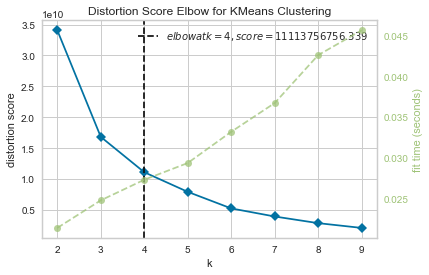

In [23]:
model= KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(data.values.reshape(-1,1))
visualizer.poof()

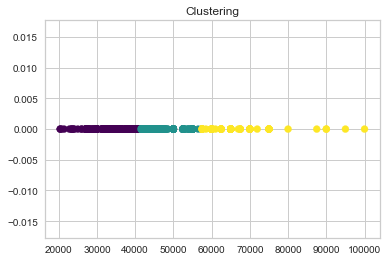

In [24]:
label_3_mean = KMeans(n_clusters=3).fit_predict(data.values.reshape(-1,1))
plt.title('Clustering')
plt.scatter(data, np.zeros_like(data), c=label_3_mean, cmap='viridis')
plt.show()

In [25]:
df_annually["label_3_mean"]= pd.Series(label_3_mean)

In [26]:
data2 = df_annually[['salary_min','salary_max']]

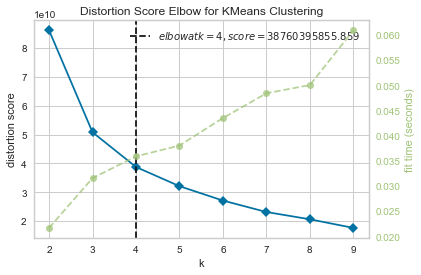

In [27]:
model= KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(data2)
visualizer.poof()

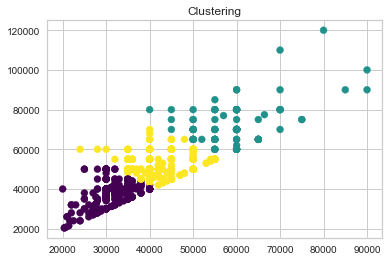

In [28]:
clusters = KMeans(n_clusters=3).fit_predict(data.values.reshape(-1,1))
plt.title('Clustering')
plt.scatter(data2['salary_min'], data2['salary_max'], c=clusters, cmap='viridis')
plt.show()

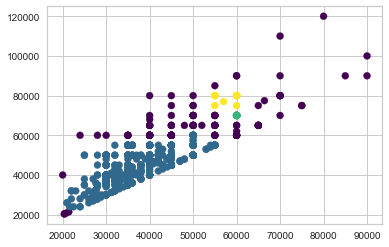

535
535
[-1  0  1  2]


In [29]:
#d = StandardScaler().fit_transform(data2)

db = DBSCAN(eps=4900, min_samples=15).fit(data2)
labels = db.labels_

plt.scatter(data2['salary_min'], data2['salary_max'], c=labels, cmap='viridis')
plt.show()

print(len(db.core_sample_indices_ ))
print(len(db.components_))
print(np.unique(db.labels_))

In [30]:
df_annually["label_min_max"]= pd.Series(clusters)
df_annually

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,city,cp,salary_min,salary_max,salary_type,salary_mean,salary_label_quartiles,label_3_mean,label_min_max
0,p_008d77a008590232,INGÉNIEUR DÉVELOPPEUR C++ / JAVA F/H,ALTEN,Toulouse (31),30 000 € - 45 000 € par an,Partenaire technologique de référence des plus...,08/09/2019,Développeur,Haute-Garonne,Toulouse,31,30000.0,45000.0,annually,37500.0,0,0,0
1,p_00f2ad8db3c30b8e,Devops F/H,Kent FR,Bordeaux (33),35 000 € - 40 000 € par an,"KENT, marque de GroupAgora dédiée aux recrutem...",09/03/2019,Développeur,Gironde,Bordeaux,33,35000.0,40000.0,annually,37500.0,0,0,0
2,p_00fa03a21ad52a71,Data Scientist H/F,QYSY,Paris (75),40 000 € - 65 000 € par an,QYSY est un cabinet de conseil et de recruteme...,29/09/2019,Data,75,Paris,75,40000.0,65000.0,annually,52500.0,3,1,2
3,p_0130bef769eef3cc,BUSINESS DEVELOPER BTOB - DATA INTELLIGENCE (H/F),L.I.P,Lyon 3e (69),35 000 € - 60 000 € par an,69003 - Lyon-3e-Arrondissement CDI Bac+5 et pl...,07/10/2019,Data,Rhône,Lyon,69,35000.0,60000.0,annually,47500.0,2,1,2
4,p_019d01b7494dc632,Référent fonctionnel et données - Data manager...,GARCIN FINANCES ET PARTICIPATIONS,Corbas (69),40 000 € - 45 000 € par an,Vous souhaitez participer à la structuration d...,10/09/2019,Data,Rhône,Corbas,69,40000.0,45000.0,annually,42500.0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,pj_f74c94c78f09bd8e,Senior Data Scientist,Pivot & Co,Paris 8e (75),60 000 € par an,"Areas: Data Science, Media Effectiveness, ROI,...",05/10/2019,Data,75,Paris,75,60000.0,60000.0,annually,60000.0,3,2,1
671,pj_f9b2d5fe629ccfb3,DevOps (H/F),EASY PARTNER,Paris (75),50 000 € - 55 000 € par an,### LE POSTE Afin d’accompagner sa forte croi...,08/10/2019,Développeur,75,Paris,75,50000.0,55000.0,annually,52500.0,3,1,2
672,pj_fd8e78ca8bedfe98,Web Developpeur,CLERE / JES,Loire-Atlantique,22 000 € - 28 000 € par an,"Éditeur de logiciels, nous développons en inte...",NaN,Développeur,Loire-Atlantique,Loire-Atlantique,None,22000.0,28000.0,annually,25000.0,0,0,0
673,pj_fe470d6a829fdecc,Consultant Devops - H/F,Des Systèmes et des Hommes,Paris 9e (75),45 000 € par an,Docker / Hibernate / Linux / Jenkins / Oracle-...,NaN,Développeur,75,Paris,75,45000.0,45000.0,annually,45000.0,1,1,2


# Création colonne class label par rapport aux tertiles salary mean

In [31]:
tercile_1 = np.quantile(df_annually.salary_mean, 1/3)
tercile_1

40000.0

In [32]:
tercile_2 = np.quantile(df_annually.salary_mean, 2/3)
tercile_2

48000.0

In [33]:
def classification_tertile(x):
    if x <= tercile_1:
        label = 1
    elif x <= tercile_2:
        label = 2
    else:
        label = 3
    return label

df_annually["salary_label_tertiles"] = df_annually["salary_mean"].apply(classification_tertile)

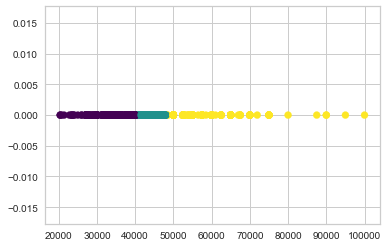

In [37]:
plt.scatter(data, np.zeros_like(data), c=df_annually.salary_label_tertiles, cmap='viridis')
plt.show()

In [162]:
df_annually

,_id,Title,Company,Location,Salary,Description,Date,Job_Search,Department_Search,city,cp,salary_min,salary_max,salary_type,salary_mean,salary_label_quartiles,label_3_mean,label_min_max,salary_label_tertiles
0,p_008d77a008590232,INGÉNIEUR DÉVELOPPEUR C++ / JAVA F/H,ALTEN,Toulouse (31),30 000 € - 45 000 € par an,Partenaire technologique de référence des plus...,08/09/2019,Développeur,Haute-Garonne,Toulouse,31,30000.0,45000.0,annually,37500.0,0,0,0,1
1,p_00f2ad8db3c30b8e,Devops F/H,Kent FR,Bordeaux (33),35 000 € - 40 000 € par an,"KENT, marque de GroupAgora dédiée aux recrutem...",09/03/2019,Développeur,Gironde,Bordeaux,33,35000.0,40000.0,annually,37500.0,0,0,0,1
2,p_00fa03a21ad52a71,Data Scientist H/F,QYSY,Paris (75),40 000 € - 65 000 € par an,QYSY est un cabinet de conseil et de recruteme...,29/09/2019,Data,75,Paris,75,40000.0,65000.0,annually,52500.0,3,1,2,3
3,p_0130bef769eef3cc,BUSINESS DEVELOPER BTOB - DATA INTELLIGENCE (H/F),L.I.P,Lyon 3e (69),35 000 € - 60 000 € par an,69003 - Lyon-3e-Arrondissement CDI Bac+5 et pl...,07/10/2019,Data,Rhône,Lyon,69,35000.0,60000.0,annually,47500.0,2,1,2,2
4,p_019d01b7494dc632,Référent fonctionnel et données - Data manager...,GARCIN FINANCES ET PARTICIPATIONS,Corbas (69),40 000 € - 45 000 € par an,Vous souhaitez participer à la structuration d...,10/09/2019,Data,Rhône,Corbas,69,40000.0,45000.0,annually,42500.0,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,pj_f74c94c78f09bd8e,Senior Data Scientist,Pivot & Co,Paris 8e (75),60 000 € par an,"Areas: Data Science, Media Effectiveness, ROI,...",05/10/2019,Data,75,Paris,75,60000.0,60000.0,annually,60000.0,3,2,1,3
671,pj_f9b2d5fe629ccfb3,DevOps (H/F),EASY PARTNER,Paris (75),50 000 € - 55 000 € par an,### LE POSTE Afin d’accompagner sa forte croi...,08/10/2019,Développeur,75,Paris,75,50000.0,55000.0,annually,52500.0,3,1,2,3
672,pj_fd8e78ca8bedfe98,Web Developpeur,CLERE / JES,Loire-Atlantique,22 000 € - 28 000 € par an,"Éditeur de logiciels, nous développons en inte...",NaN,Développeur,Loire-Atlantique,Loire-Atlantique,None,22000.0,28000.0,annually,25000.0,0,0,0,1
673,pj_fe470d6a829fdecc,Consultant Devops - H/F,Des Systèmes et des Hommes,Paris 9e (75),45 000 € par an,Docker / Hibernate / Linux / Jenkins / Oracle-...,NaN,Développeur,75,Paris,75,45000.0,45000.0,annually,45000.0,1,1,2,2


In [163]:
#stopwords
stop_words_en = stopwords.words('english')
stop_words_fr = stopwords.words('french')

# Prediction salaire avec job desc brut seulement

In [164]:
from sklearn.feature_extraction.text import CountVectorizer

- Choix du X_desc en le nettoyant pour ne pas avoir les infos salaire et choix du y

In [225]:
X_desc = df_annually.Description.str.replace("\n"," ").str.replace(r'\b\d\d\W?\d\d\d\b\W?(\d\d)?','').str.replace(r'\+',' plus ').str.replace(r'\b\d\W?\d\d\d\W?(\d\d)?\b','').str.replace(r'\b\d\d\W\d\d[kK]?\b','').str.replace(r'\b\d\d[kK]\W?','')
y = df_annually.label_3_mean # <- à changer à chaque fois qu'on veut relancer avec différent y_label

- choix des stopwords à utliser avec CountVectorizer

In [226]:
#stop_words_en.remove('an') #  <- décocher si jamais run
stop_words_en_fr = stop_words_en + stop_words_fr + ["h","f", "mois", "ci", "e", "salaire", "avoir", "offres", "description", "emploi", "véritables", "recherche", "travail", "intégrer", "suivates", "cette", "recherchons", "travailler", "définir", "similaire", "aujourd'hui"]

- Utilisation de CountVectorizer

In [227]:
cv = CountVectorizer(token_pattern = r'\b\w+\b',stop_words=stop_words_en_fr,  ngram_range=(1, 3), min_df = 2)
cv.fit(X_desc)

/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aujourd', 'hui'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=2,
                ngram_range=(1, 3), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='\\b\\w+\\b', tokenizer=None,
                vocabulary=None)

In [228]:
len(cv.get_feature_names())

40915

In [229]:
X_desc_trans = cv.transform(X_desc)
#X_desc_trans = pd.DataFrame(cv.transform(X_desc).todense(), columns=cv.get_feature_names())
#X_desc_trans

In [230]:
#word_counts = X_desc_trans.sum(axis=0)
#word_counts.sort_values(ascending = False).head(20)

- Prédiction avec RandomForestClassifier

In [231]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train, y_test = train_test_split(X_desc_trans, y, test_size=0.3, random_state=0, stratify=y)


rfc = RandomForestClassifier(300, random_state=0)

n_estimators = [200, 250, 300, 350, 400]
criterion = ["gini", "entropy"]
#max_depth = [X.shape[1]*0.01, X.shape[1]*0.03, X.shape[1]*0.05, X.shape[1]*0.07, X.shape[1]*0.09]

param_grid = {'n_estimators': n_estimators, "criterion" : criterion}
grid = GridSearchCV(rfc, param_grid =param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(X_test, y_test) * 100 ) )



#rfc.score(X_test,y_test)

/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameters are {'criterion': 'entropy', 'n_estimators': 300} with a score of 64
Best estimator accuracy on test set 65.52 


In [232]:
rfc.fit(X_train, y_train)

rfc.score(X_test,y_test)

0.6896551724137931

In [233]:
grid.best_estimator_.score(X_train, y_train)*100

100.0

In [234]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.902524,0.043660,0.085626,0.006570,gini,200,"{'criterion': 'gini', 'n_estimators': 200}",0.625000,0.595745,0.638298,0.627660,0.617021,0.620763,0.014206,9
1,2.371501,0.147800,0.098292,0.009027,gini,250,"{'criterion': 'gini', 'n_estimators': 250}",0.635417,0.595745,0.638298,0.670213,0.617021,0.631356,0.024640,6
2,2.768129,0.049120,0.132128,0.007036,gini,300,"{'criterion': 'gini', 'n_estimators': 300}",0.614583,0.585106,0.638298,0.659574,0.606383,0.620763,0.025756,9
3,3.197096,0.092821,0.129250,0.002094,gini,350,"{'criterion': 'gini', 'n_estimators': 350}",0.625000,0.595745,0.627660,0.670213,0.606383,0.625000,0.025456,8
4,3.523866,0.105400,0.144744,0.003861,gini,400,"{'criterion': 'gini', 'n_estimators': 400}",0.635417,0.595745,0.659574,0.670213,0.617021,0.635593,0.027169,5
5,1.831623,0.047771,0.073905,0.001427,entropy,200,"{'criterion': 'entropy', 'n_estimators': 200}",0.666667,0.606383,0.659574,0.617021,0.606383,0.631356,0.026486,6
6,2.291699,0.042666,0.091031,0.002602,entropy,250,"{'criterion': 'entropy', 'n_estimators': 250}",0.677083,0.617021,0.659574,0.627660,0.606383,0.637712,0.026671,3
7,2.763632,0.051700,0.111171,0.003957,entropy,300,"{'criterion': 'entropy', 'n_estimators': 300}",0.666667,0.606383,0.670213,0.659574,0.617021,0.644068,0.026766,1
8,3.172377,0.057785,0.124058,0.008753,entropy,350,"{'criterion': 'entropy', 'n_estimators': 350}",0.656250,0.606383,0.659574,0.648936,0.617021,0.637712,0.021700,3
9,3.183105,0.215797,0.106118,0.006162,entropy,400,"{'criterion': 'entropy', 'n_estimators': 400}",0.656250,0.606383,0.648936,0.670213,0.617021,0.639831,0.024116,2


In [235]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = cv.get_feature_names()).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False).head(50)

,feature,importance
18537,informatique,0.005612
25447,paris,0.005116
4657,bac plus 2,0.003080
27187,plus 2,0.002901
10758,devops,0.002416
10130,data,0.002386
4541,aws,0.002343
40295,équipes,0.002065
38072,type,0.002031
18765,infrastructure,0.001964


In [236]:
#list(X_desc[X_desc.str.contains("10 ans")])

# Prédiction salaire avec Title seulement

In [237]:
X_title = df_annually.Title.str.replace("\n"," ").str.replace("/"," ")

In [238]:
cv2 = CountVectorizer( token_pattern=r'\b[^\d\W]+\b', stop_words=stop_words_en_fr, ngram_range=(1, 2))
cv2.fit(X_title)

/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aujourd', 'hui'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='\\b[^\\d\\W]+\\b',
                tokenizer=None, vocabulary=None)

In [239]:
len(cv2.get_feature_names())

1282

In [240]:
X_title_trans = cv2.transform(X_title)
#X_title_trans = pd.DataFrame(cv2.transform(X_title).todense(), columns=cv2.get_feature_names())
#X_title_trans

In [241]:
#word_counts2 = X_title_trans.sum(axis=0)
#word_counts2.sort_values(ascending = False).head(30)

In [242]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_title_trans, y, test_size=0.3, random_state=10, stratify=y)


rfc = RandomForestClassifier(50, random_state=0)

n_estimators = [25, 50, 75, 100, 300]
criterion = ["gini", "entropy"]
#max_depth = [X.shape[1]*0.01, X.shape[1]*0.03, X.shape[1]*0.05, X.shape[1]*0.07, X.shape[1]*0.09]

param_grid = {'n_estimators': n_estimators, "criterion" : criterion}
grid = GridSearchCV(rfc, param_grid =param_grid, cv=10, n_jobs=-1, scoring='accuracy')
grid.fit(X_train2, y_train2)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(X_test2, y_test2) * 100 ) )


/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameters are {'criterion': 'gini', 'n_estimators': 75} with a score of 63
Best estimator accuracy on test set 57.14 


In [243]:
rfc.fit(X_train2, y_train2)

rfc.score(X_test2,y_test2)

0.5665024630541872

In [244]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = cv2.get_feature_names()).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False).head(30)

,feature,importance
207,data,0.027234
358,développeur,0.026926
286,devops,0.019674
755,lead,0.019229
471,engineer,0.012699
758,lead data,0.011941
744,junior,0.011533
657,ingénieur,0.010914
1059,senior,0.010752
388,développeur informatique,0.009883


# Prédiction salaire avec ville

In [245]:
df_annually.city.unique()

array(['Toulouse ', 'Bordeaux ', 'Paris', 'Lyon', 'Corbas ', 'Nantes ',
       'Pessac ', 'Limonest ', 'Portet-sur-Garonne ', 'Blagnac ',
       'Talence ', 'Villeneuve-lès-Bouloc ', 'Mérignac ', 'Marennes ',
       'Rillieux-la-Pape ', 'Canéjan ', 'Beauzelle ',
       "Saint-Didier-au-Mont-d'Or ", 'Villeurbanne ', 'Lissieu ',
       'Gradignan ', 'Treillières ', 'Loire-Atlantique', 'Limas ',
       'Rhône', 'Labège ', 'Saint-Pierre-de-Chandieu ', 'Saint-Nazaire ',
       'Ancenis ', 'Vénissieux ', 'Chassieu ', 'Dardilly ',
       'Saint-Orens-de-Gameville ', 'Bruges ', 'Brignais ',
       'Saint-Herblain ', 'Châteaubriant ', 'Francheville ', 'Bron ',
       'Carquefou ', 'Toussieu ', 'Charbonnières-les-Bains ',
       'Saint-Médard-en-Jalles ', 'Le Haillan ', 'Castanet-Tolosan ',
       "L'Union ", 'Tassin-la-Demi-Lune ', 'Écully '], dtype=object)

In [246]:
city_d = pd.get_dummies(df_annually.city)
X_city = city_d

X_train, X_test, y_train, y_test = train_test_split(X_city, y, test_size=0.3, random_state=0, stratify=y)

In [247]:
rfc = RandomForestClassifier(300, random_state=0)

n_estimators = [75, 100, 200, 300, 400]
criterion = ["gini", "entropy"]
#max_depth = [X.shape[1]*0.01, X.shape[1]*0.03, X.shape[1]*0.05, X.shape[1]*0.07, X.shape[1]*0.09]

param_grid = {'n_estimators': n_estimators, "criterion" : criterion}
grid = GridSearchCV(rfc, param_grid =param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(X_test, y_test) * 100 ) )

The best parameters are {'criterion': 'gini', 'n_estimators': 400} with a score of 63
Best estimator accuracy on test set 65.52 


In [248]:
rfc.fit(X_train, y_train)

rfc.score(X_test,y_test)

0.6551724137931034

In [249]:
X_city.columns

Index(['Ancenis ', 'Beauzelle ', 'Blagnac ', 'Bordeaux ', 'Brignais ', 'Bron ',
       'Bruges ', 'Canéjan ', 'Carquefou ', 'Castanet-Tolosan ',
       'Charbonnières-les-Bains ', 'Chassieu ', 'Châteaubriant ', 'Corbas ',
       'Dardilly ', 'Francheville ', 'Gradignan ', 'L'Union ', 'Labège ',
       'Le Haillan ', 'Limas ', 'Limonest ', 'Lissieu ', 'Loire-Atlantique',
       'Lyon', 'Marennes ', 'Mérignac ', 'Nantes ', 'Paris', 'Pessac ',
       'Portet-sur-Garonne ', 'Rhône', 'Rillieux-la-Pape ',
       'Saint-Didier-au-Mont-d'Or ', 'Saint-Herblain ',
       'Saint-Médard-en-Jalles ', 'Saint-Nazaire ',
       'Saint-Orens-de-Gameville ', 'Saint-Pierre-de-Chandieu ', 'Talence ',
       'Tassin-la-Demi-Lune ', 'Toulouse ', 'Toussieu ', 'Treillières ',
       'Villeneuve-lès-Bouloc ', 'Villeurbanne ', 'Vénissieux ', 'Écully '],
      dtype='object')

In [250]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_city.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False)

,feature,importance
28,Paris,0.496949
41,Toulouse,0.095242
27,Nantes,0.078740
24,Lyon,0.063299
3,Bordeaux,0.038715
40,Tassin-la-Demi-Lune,0.023881
7,Canéjan,0.014700
21,Limonest,0.014695
47,Écully,0.014538
8,Carquefou,0.012857


In [251]:
#n_estimators = np.linspace(start = 600 , stop = 1000, num = 8, dtype= int )
#n_estimators
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

param_grid = {'n_estimators': n_estimators}
grid = GridSearchCV(rfc, param_grid =param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(X_test, y_test) * 100 ) )

The best parameters are {'n_estimators': 50} with a score of 64
Best estimator accuracy on test set 65.02 


In [252]:
df_annually.Department_Search.unique()

array(['Haute-Garonne', 'Gironde', '75', 'Rhône', 'Loire-Atlantique'],
      dtype=object)

In [253]:
depart_d = pd.get_dummies(df_annually.Department_Search)
X_depart = depart_d

X_train, X_test, y_train, y_test = train_test_split(X_depart, y, test_size=0.3, random_state=0, stratify=y)

n_estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

param_grid = {'n_estimators': n_estimators}
grid = GridSearchCV(rfc, param_grid =param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(X_test, y_test) * 100 ) )

The best parameters are {'n_estimators': 50} with a score of 64
Best estimator accuracy on test set 65.52 


In [254]:
rfc = RandomForestClassifier(50, random_state=0)
rfc.fit(X_train, y_train)

feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_depart.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False)

,feature,importance
0,75,0.583542
2,Haute-Garonne,0.160866
4,Rhône,0.108138
3,Loire-Atlantique,0.098067
1,Gironde,0.049388


In [255]:
df_annually.to_csv("df_annually.csv")

# Fonction plot confusion matrix

In [256]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


# Split the data into a training set and a test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
#classifier = svm.SVC(kernel='linear', C=0.01)
#y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names,
#                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
 #                     title='Normalized confusion matrix')

#plt.show()

# Prediction avec les X_desc_trans, X_title_trans et X_city

- Feature types

In [257]:
print(type(X_desc_trans))
print(type(X_title_trans))
print(type(X_city))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'pandas.core.frame.DataFrame'>


- On convertit X_desc_trans et X_title_trans en DF pour pouvoir les concatener

In [258]:
X_desc_df = pd.DataFrame(X_desc_trans.todense(), columns=cv.get_feature_names())
X_title_df = pd.DataFrame(X_title_trans.todense(), columns=cv2.get_feature_names())
X_city_df = X_city.reset_index(drop = True)

In [259]:
X = pd.concat([X_desc_df, X_title_df, X_city_df], axis=1)

In [260]:
X_city

,Ancenis,Beauzelle,Blagnac,Bordeaux,Brignais,Bron,Bruges,Canéjan,Carquefou,Castanet-Tolosan,...,Saint-Pierre-de-Chandieu,Talence,Tassin-la-Demi-Lune,Toulouse,Toussieu,Treillières,Villeneuve-lès-Bouloc,Villeurbanne,Vénissieux,Écully
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [261]:
X

,0,0 2,0 2 ans,000,000 inscrits,000 inscrits plus,000 iziworkers,000 iziworkers inscrits,000 professionnels,000 professionnels 90,...,Saint-Pierre-de-Chandieu,Talence,Tassin-la-Demi-Lune,Toulouse,Toussieu,Treillières,Villeneuve-lès-Bouloc,Villeurbanne,Vénissieux,Écully
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 - Application du PCA

In [262]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

pca = PCA(.95)
pca.fit(X_train)
x_train_pca = pca.transform(X_train)
x_test_pca = pca.transform(X_test)

print ("On est passé de {} colonnes à {} colonnes".format(X.shape[1],len(pca.explained_variance_ratio_)))

On est passé de 42245 colonnes à 343 colonnes


- Logistic sans PCA

In [263]:
logistic = LogisticRegression(random_state =0)
logistic.fit(X_train, y_train)
print("L'accuracy est de {:.2f} %".format(logistic.score(X_test,y_test)*100))

/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


L'accuracy est de 69.46 %


In [264]:
logistic.score(X_train, y_train) * 100

100.0

Confusion matrix, without normalization
[[63 13  2]
 [22 65  3]
 [ 2 20 13]]


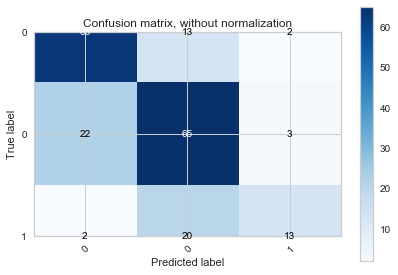

In [265]:
y_pred=logistic.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=y,
                      title='Confusion matrix, without normalization')
plt.show()

In [266]:
feature_importances = pd.DataFrame(logistic.coef_[0],
                                   index = X_train.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False).head(50)

,feature,importance
18537,informatique,0.489752
41659,junior,0.357493
23769,nantes,0.318846
30643,r,0.301923
8036,compte,0.264689
26663,php,0.253157
5407,bordeaux,0.252488
27203,plus 3,0.239960
41273,développeur,0.234344
9872,css,0.232505


- logistic avec PCA

In [267]:
logistic.fit(x_train_pca, y_train)
print("L'accuracy est de {:.2f} %".format(logistic.score(x_test_pca,y_test)*100))

L'accuracy est de 66.01 %


/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [268]:
logistic.score(x_train_pca, y_train) * 100

99.78813559322035

- SVM grid search sans PCA

In [269]:
kernel = ["linear", "poly", "rbf","sigmoid"]

svc=SVC(gamma='auto')

param_grid = {'kernel': kernel}
grid = GridSearchCV(svc, param_grid =param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(X_test, y_test) * 100 ) )

/Users/Ivan/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameters are {'kernel': 'linear'} with a score of 65
Best estimator accuracy on test set 70.94 


In [270]:
grid.best_estimator_.score(X_train, y_train)*100

100.0

Confusion matrix, without normalization
[[61 15  2]
 [19 69  2]
 [ 1 20 14]]


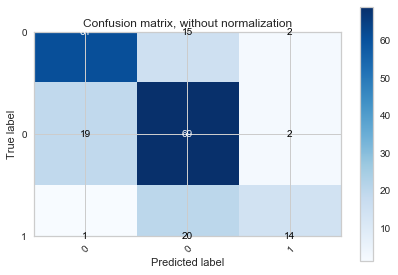

In [271]:
y_pred=grid.best_estimator_.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=y,
                      title='Confusion matrix, without normalization')
plt.show()

- SVM grid avec PCA

In [272]:
grid.fit(x_train_pca, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(x_test_pca, y_test) * 100 ) )

The best parameters are {'kernel': 'sigmoid'} with a score of 68
Best estimator accuracy on test set 65.02 


/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [273]:
grid.best_estimator_.score(x_train_pca, y_train) * 100

81.99152542372882

- Random forest classifier sans PCA

In [274]:
n_estimators = [100, 200, 250, 300, 350]
criterion = ["gini", "entropy"]
#max_depth = [2, 4, 8, 16, 32, None]
max_features=[0.05]

param_grid = {'n_estimators': n_estimators, "criterion" : criterion, 'max_features' : max_features}
grid = GridSearchCV(rfc, param_grid =param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(X_test, y_test) * 100 ) )

/Users/Ivan/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameters are {'criterion': 'gini', 'max_features': 0.05, 'n_estimators': 200} with a score of 70
Best estimator accuracy on test set 66.50 


Confusion matrix, without normalization
[[57 21  0]
 [15 74  1]
 [ 2 29  4]]


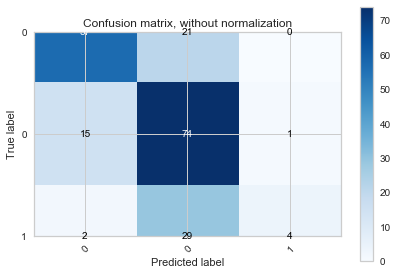

In [275]:
y_pred=grid.best_estimator_.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=y,
                      title='Confusion matrix, without normalization')
plt.show()

In [276]:
feature_importances = pd.DataFrame(grid.best_estimator_.feature_importances_,
                                   index = X_train.columns).reset_index()
feature_importances.columns = ['feature', 'importance']

feature_importances.sort_values('importance', ascending=False).head(50)

,feature,importance
42225,Paris,0.044722
18537,informatique,0.015065
25447,paris,0.013471
10130,data,0.011286
41273,développeur,0.009700
18765,infrastructure,0.007983
27187,plus 2,0.005216
13133,développeur,0.004663
27168,plus,0.004383
41659,junior,0.004361


In [277]:
print(grid.best_estimator_.score(X_train, y_train) * 100)

100.0


In [278]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,7.199500,0.109586,0.101182,0.005064,gini,0.05,100,"{'criterion': 'gini', 'max_features': 0.05, 'n...",0.670886,0.683544,0.737179,0.697034,0.028678,3
1,14.143060,0.225717,0.169104,0.013516,gini,0.05,200,"{'criterion': 'gini', 'max_features': 0.05, 'n...",0.683544,0.683544,0.737179,0.701271,0.025230,1
2,17.698670,0.387661,0.189771,0.006268,gini,0.05,250,"{'criterion': 'gini', 'max_features': 0.05, 'n...",0.670886,0.689873,0.737179,0.699153,0.027825,2
3,22.962644,1.399214,0.235691,0.095627,gini,0.05,300,"{'criterion': 'gini', 'max_features': 0.05, 'n...",0.677215,0.683544,0.724359,0.694915,0.020849,5
4,27.615212,0.410391,0.188283,0.029911,gini,0.05,350,"{'criterion': 'gini', 'max_features': 0.05, 'n...",0.677215,0.689873,0.717949,0.694915,0.016992,5
5,8.863103,1.000467,0.085753,0.002363,entropy,0.05,100,"{'criterion': 'entropy', 'max_features': 0.05,...",0.651899,0.696203,0.730769,0.692797,0.032255,7
6,15.324412,0.624470,0.124927,0.014820,entropy,0.05,200,"{'criterion': 'entropy', 'max_features': 0.05,...",0.645570,0.677215,0.737179,0.686441,0.037928,10
7,17.093852,0.248063,0.106052,0.010825,entropy,0.05,250,"{'criterion': 'entropy', 'max_features': 0.05,...",0.658228,0.677215,0.743590,0.692797,0.036524,7
8,20.930663,0.151253,0.091394,0.008785,entropy,0.05,300,"{'criterion': 'entropy', 'max_features': 0.05,...",0.651899,0.683544,0.743590,0.692797,0.037964,7
9,19.880626,1.741017,0.073552,0.001731,entropy,0.05,350,"{'criterion': 'entropy', 'max_features': 0.05,...",0.670886,0.689873,0.730769,0.697034,0.024943,3


- Random Forest Classifier avec PCA

In [279]:
grid.fit(x_train_pca, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(x_test_pca, y_test) * 100 ) )

/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameters are {'criterion': 'entropy', 'max_features': 0.05, 'n_estimators': 350} with a score of 61
Best estimator accuracy on test set 64.53 


In [280]:
print(grid.best_estimator_.score(x_train_pca, y_train) * 100)

100.0


- Adaboost sans PCA

In [285]:
from sklearn.ensemble import AdaBoostClassifier

adclassifier= AdaBoostClassifier()

n_estimators = [15,20,25,30]

param_grid = {'n_estimators': n_estimators}

grid = GridSearchCV(adclassifier, param_grid =param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(X_test, y_test) * 100 ) )

/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameters are {'n_estimators': 20} with a score of 62
Best estimator accuracy on test set 65.02 


In [286]:
print(grid.best_estimator_.score(X_train, y_train) * 100)

68.22033898305084


Confusion matrix, without normalization
[[45 32  1]
 [10 71  9]
 [ 0 19 16]]


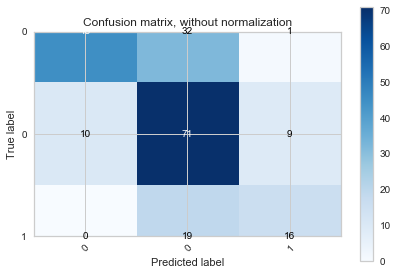

In [287]:
y_pred=grid.best_estimator_.predict(X_test)
plot_confusion_matrix(y_test, y_pred, classes=y,
                      title='Confusion matrix, without normalization')
plt.show()

- Gradient Boosting classifier

In [288]:
from sklearn.ensemble import GradientBoostingClassifier
    
gbclf = GradientBoostingClassifier()

n_estimators = [25, 50, 75, 100, 125]

param_grid = {'n_estimators': n_estimators}

grid = GridSearchCV(gbclf, param_grid =param_grid, cv=3, n_jobs=-1, scoring='accuracy')
grid.fit(x_train_pca, y_train)

print("The best parameters are %s with a score of %0.0f" % (grid.best_params_, grid.best_score_ * 100 ))
print( "Best estimator accuracy on test set {:.2f} ".format(grid.best_estimator_.score(x_test_pca, y_test) * 100 ) )

/Users/Ivan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best parameters are {'n_estimators': 50} with a score of 59
Best estimator accuracy on test set 63.55 


In [289]:
print(grid.best_estimator_.score(x_train_pca, y_train) * 100)

99.57627118644068
